In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from utils import *
from pycaret.regression import *
from IPython.display import Image

%config Completer.use_jedi = False
seed = 1

# Agenda
1. Problem
2. EDA
3. Solution
    - Base Model
    - Modeling fun with PyCaret
4. Conclusion

# 1. Problem
- Regression
- Target: **normalized losses** ~ "*relative average loss payment per insured vehicle year.*" ([UCI](https://archive.ics.uci.edu/ml/datasets/Automobile))
- Metric: MSE

In [1]:
# Get data (Skip / Modify this step if you aren't using zsh)
!zsh data/get_data.sh 2>/dev/null

Getting Data from UCI
Download complete


# 2. EDA

We are looking at a data set about old cars. The original target was probably the price. Here we'll try to predict normalized-losses. Note, the data set is very small. After cleaning there are only 164 rows left (far too less in a production-like environment).

In [6]:
df = pd.read_csv("data/imports-85.data", header=None, names=columns)
df = clean_df(df)
df.head(3)

164 rows (80.0%) left after preprocessing


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
6,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0


## A Look at Distributions and Relations

In [5]:
# Target Distribution
sns.histplot(df["normalized-losses"], bins=50)
plt.title("Distribution Target: 'normalized-losses'")
plt.savefig('img/target_dist.png', dpi=300)
plt.close()

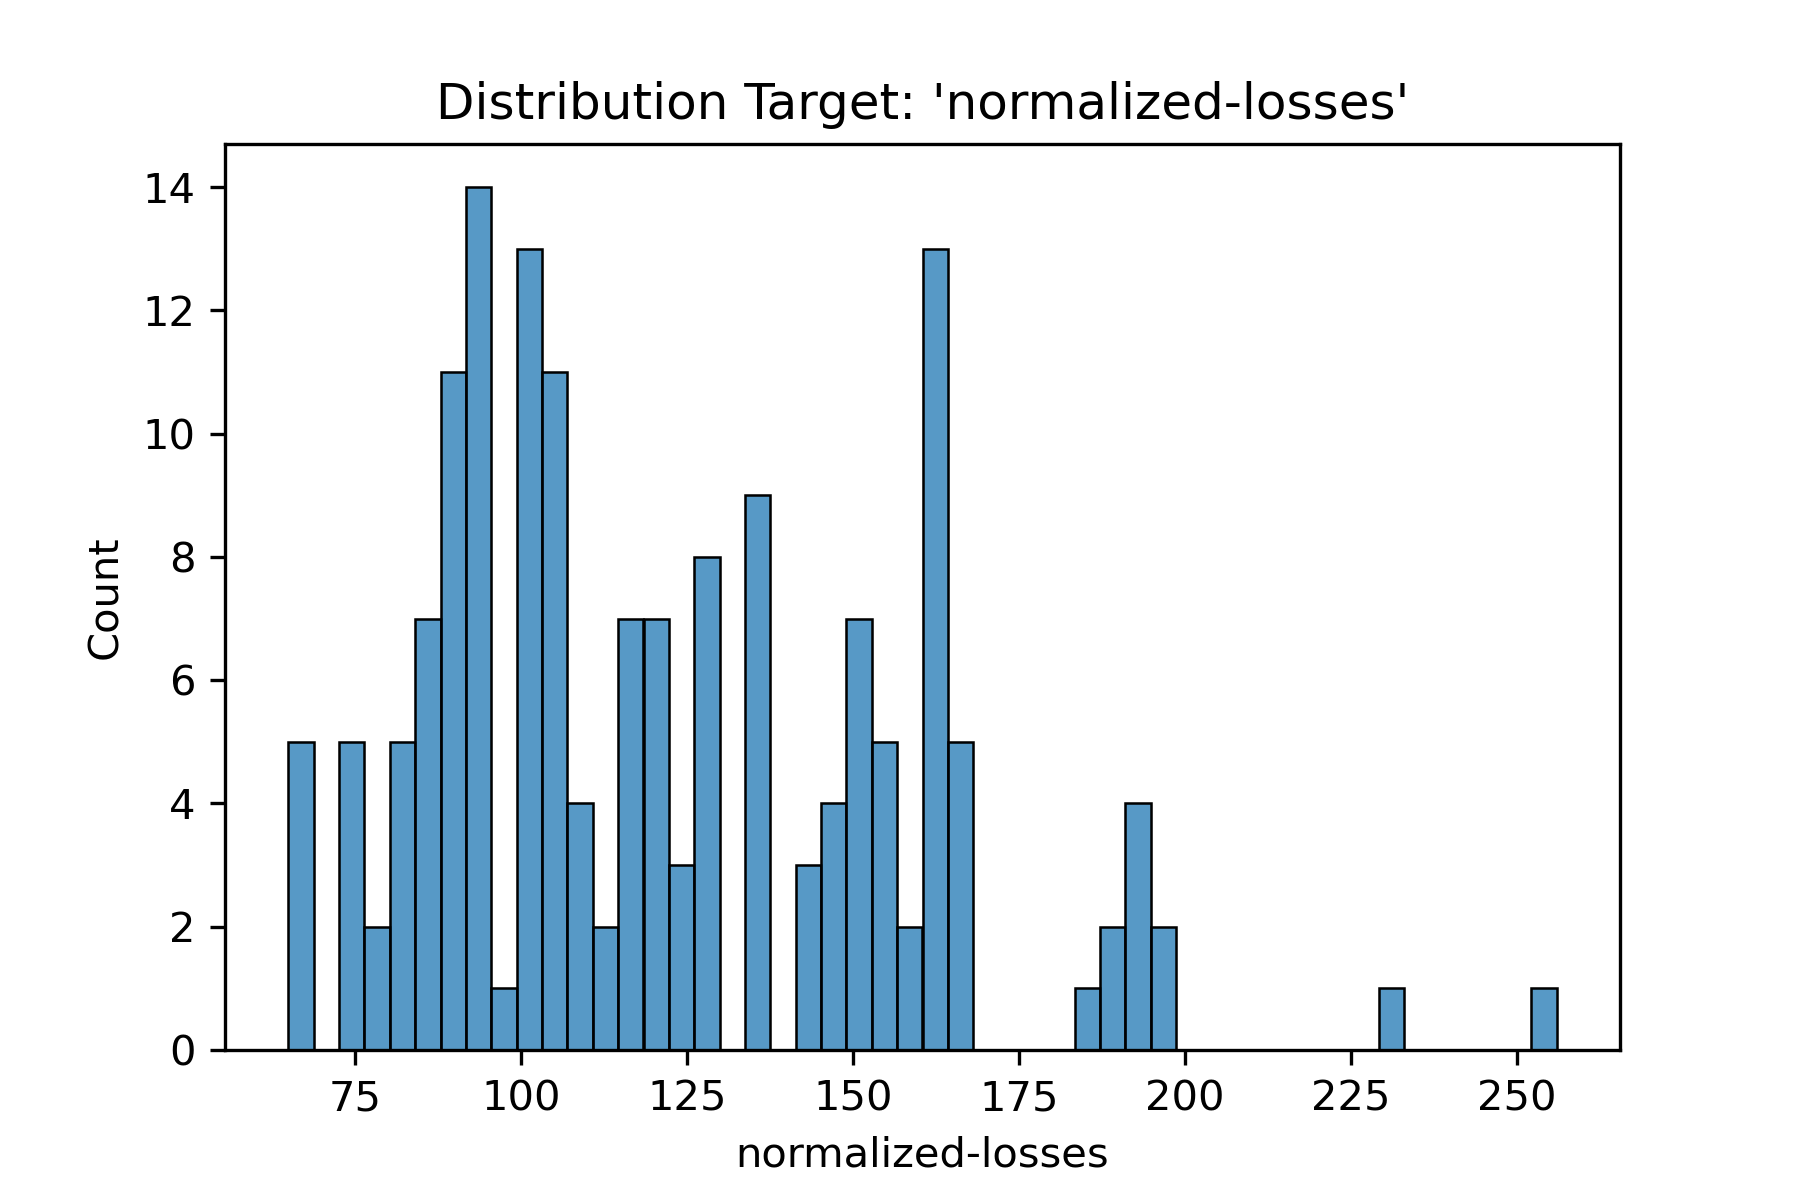

In [6]:
Image("img/target_dist.png", width = 600)

- Not much data!
- Target variable almost right skewed distribution

In [7]:
for idx, batch in enumerate(create_batches_of_columns(df)):
    sns.pairplot(df[batch],kind='reg',corner=True)
    plt.savefig(f'img/pair_plot_{idx}.png', dpi=150)
    plt.close()   

Pairplotted Relations I


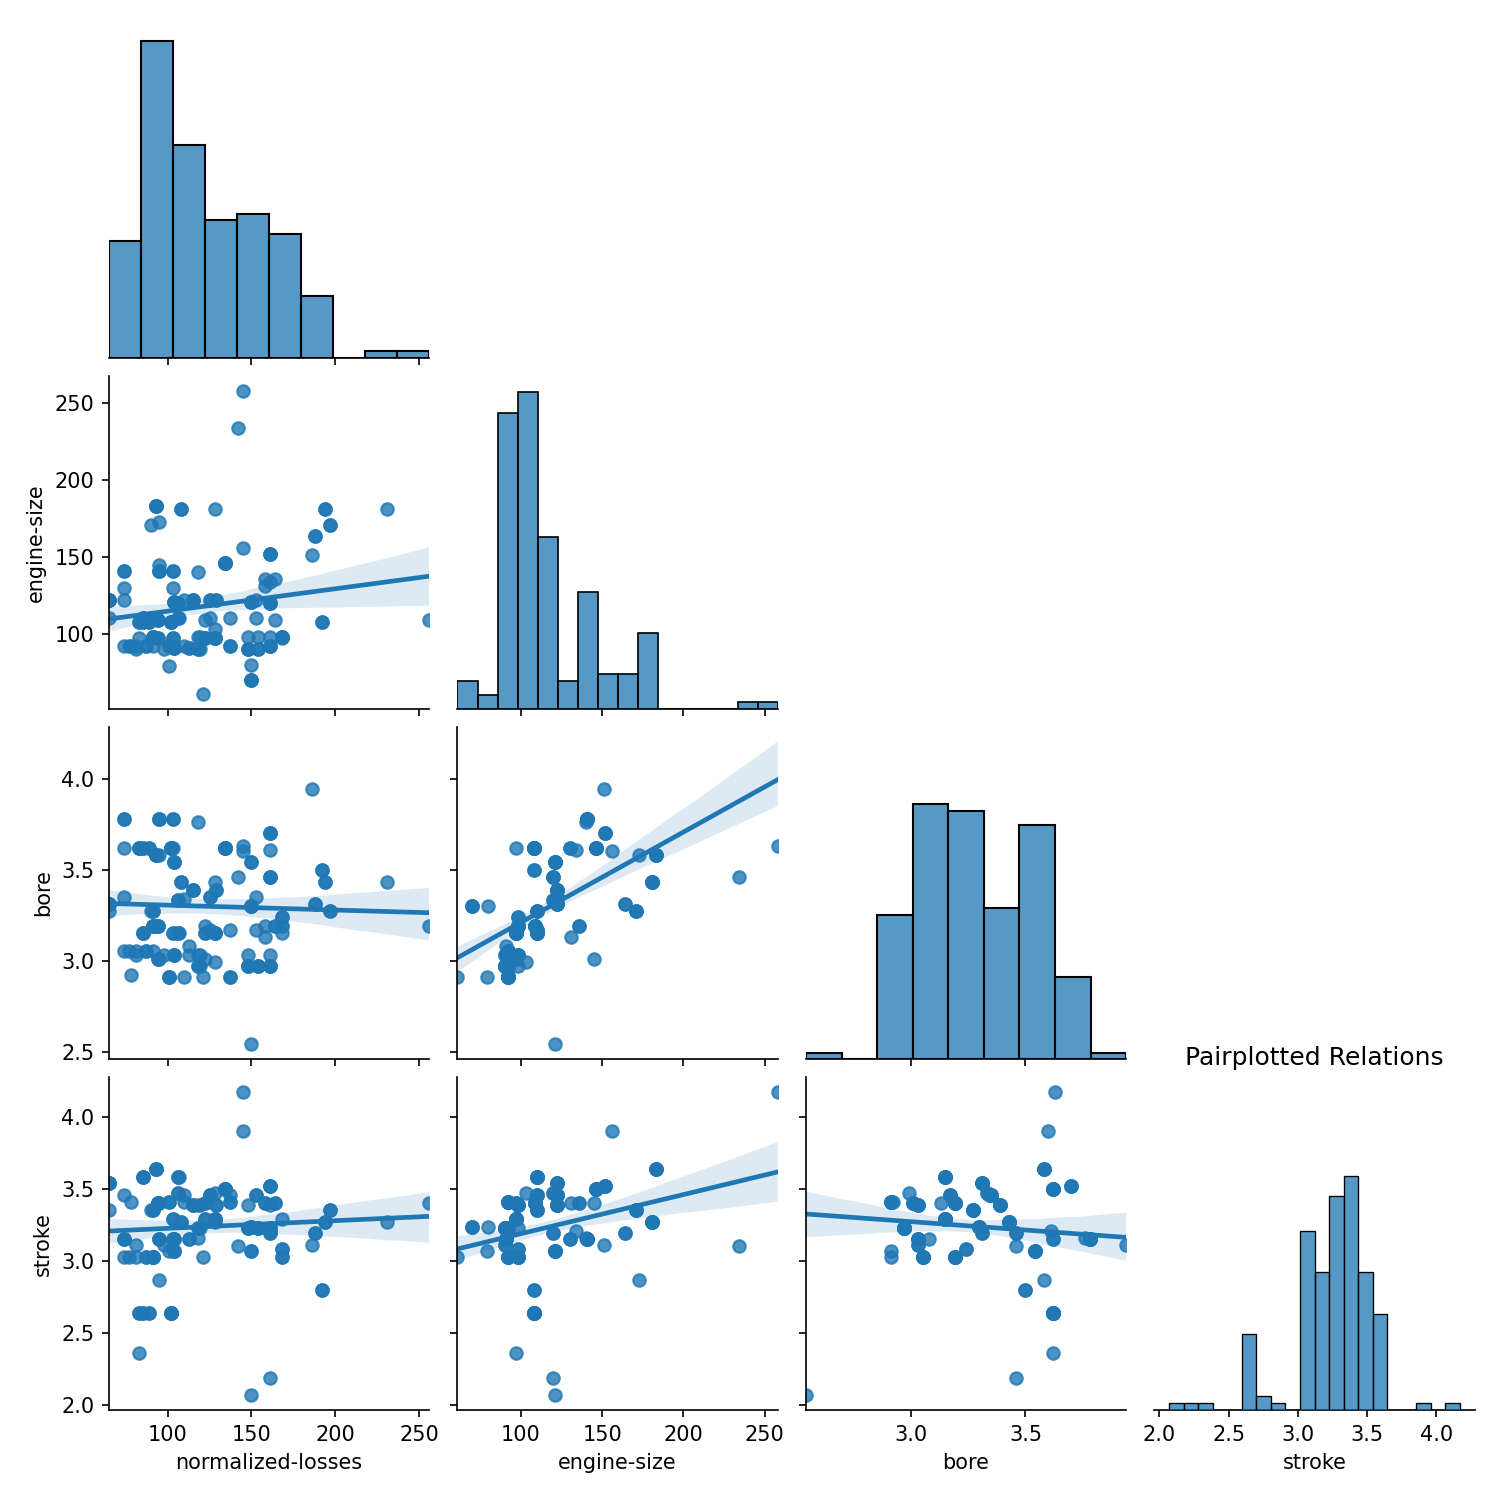

In [42]:
print("Pairplotted Relations I")
Image("img/pair_plot_2.png", width = 500)

- Small example of features
- No clear simple linear relation with normalized losses
- Spread getting bigger at normalized losses > 160

Pairplotted Relations II


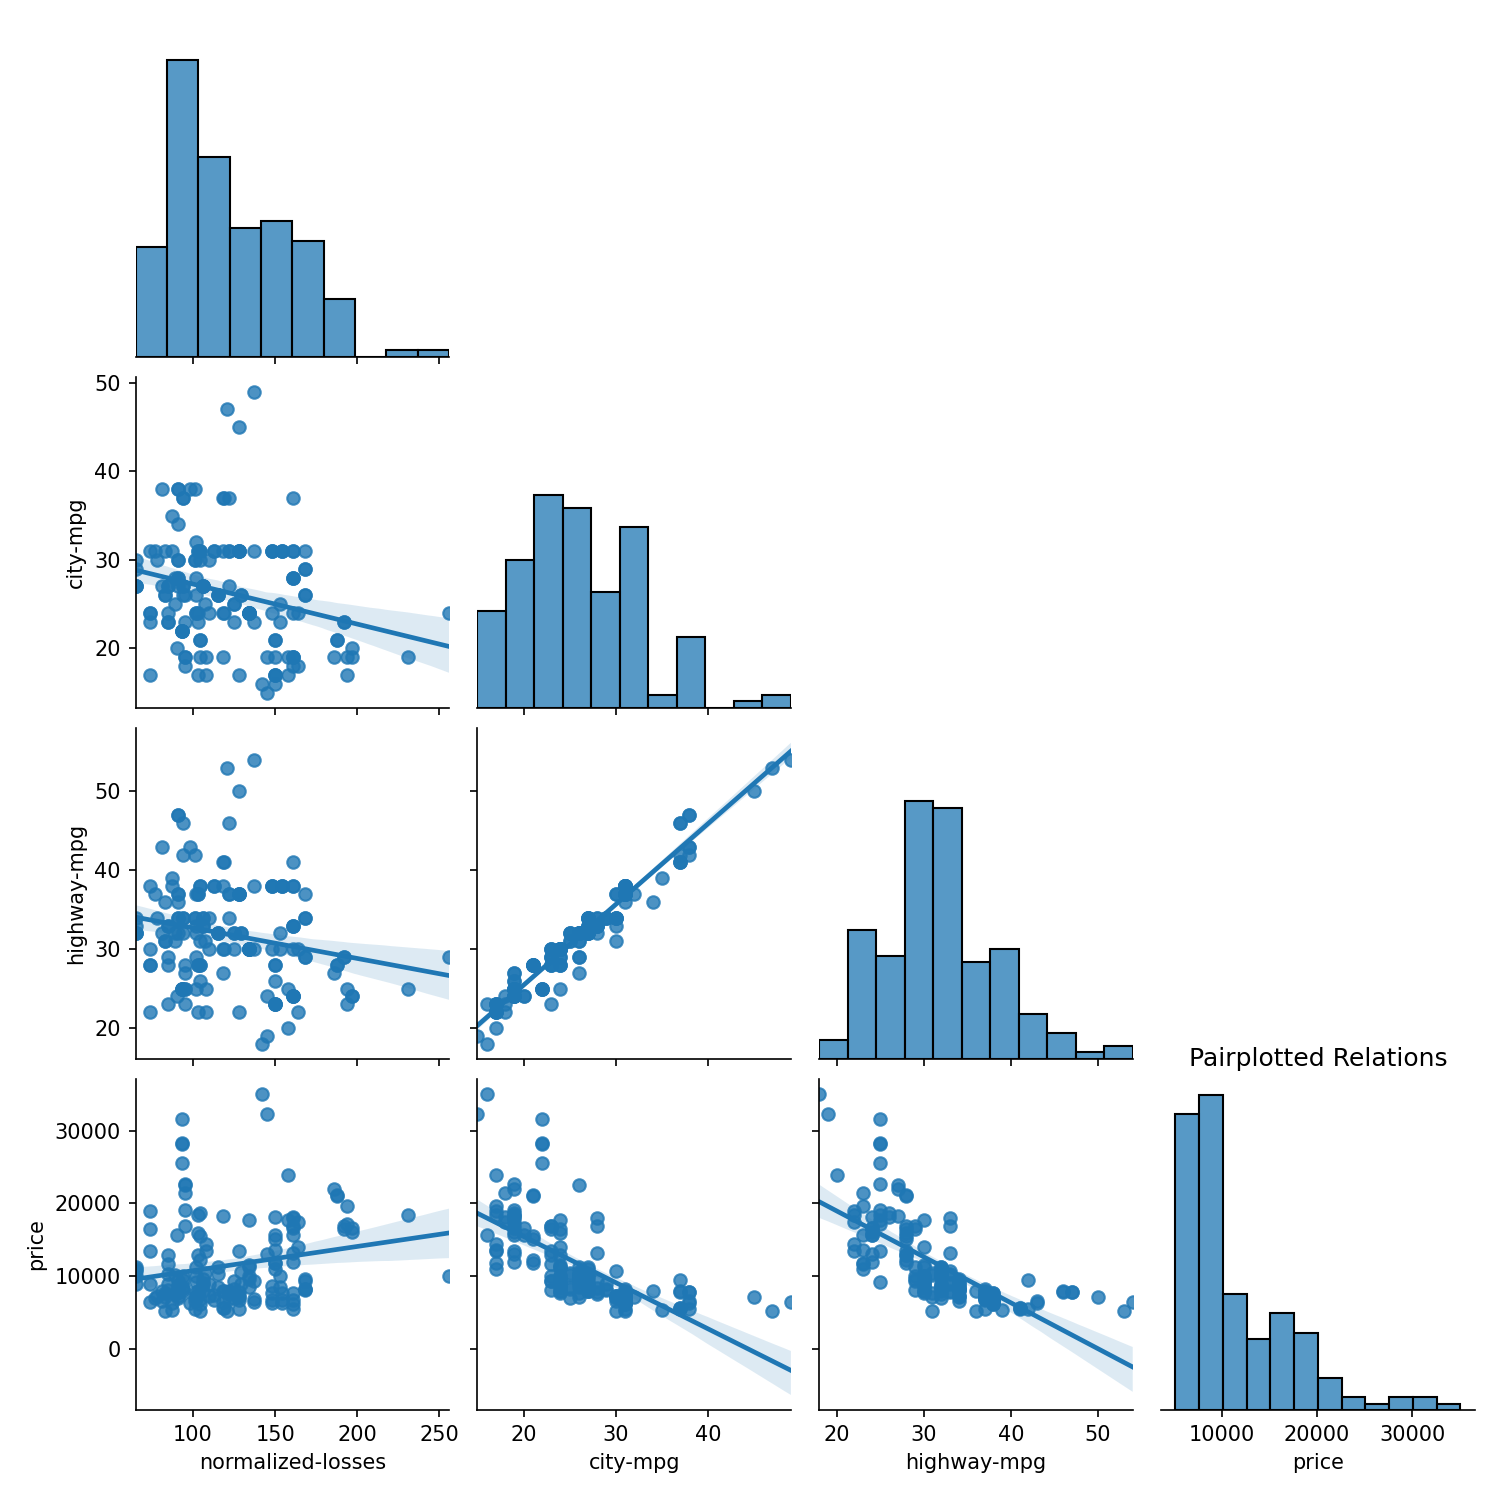

In [43]:
print("Pairplotted Relations II")
Image("img/pair_plot_4.png", width = 500)

- String linear relation between a view features (makes sense between *-mpg)
- Multicollinearity

In [16]:
plot_correlation(df)

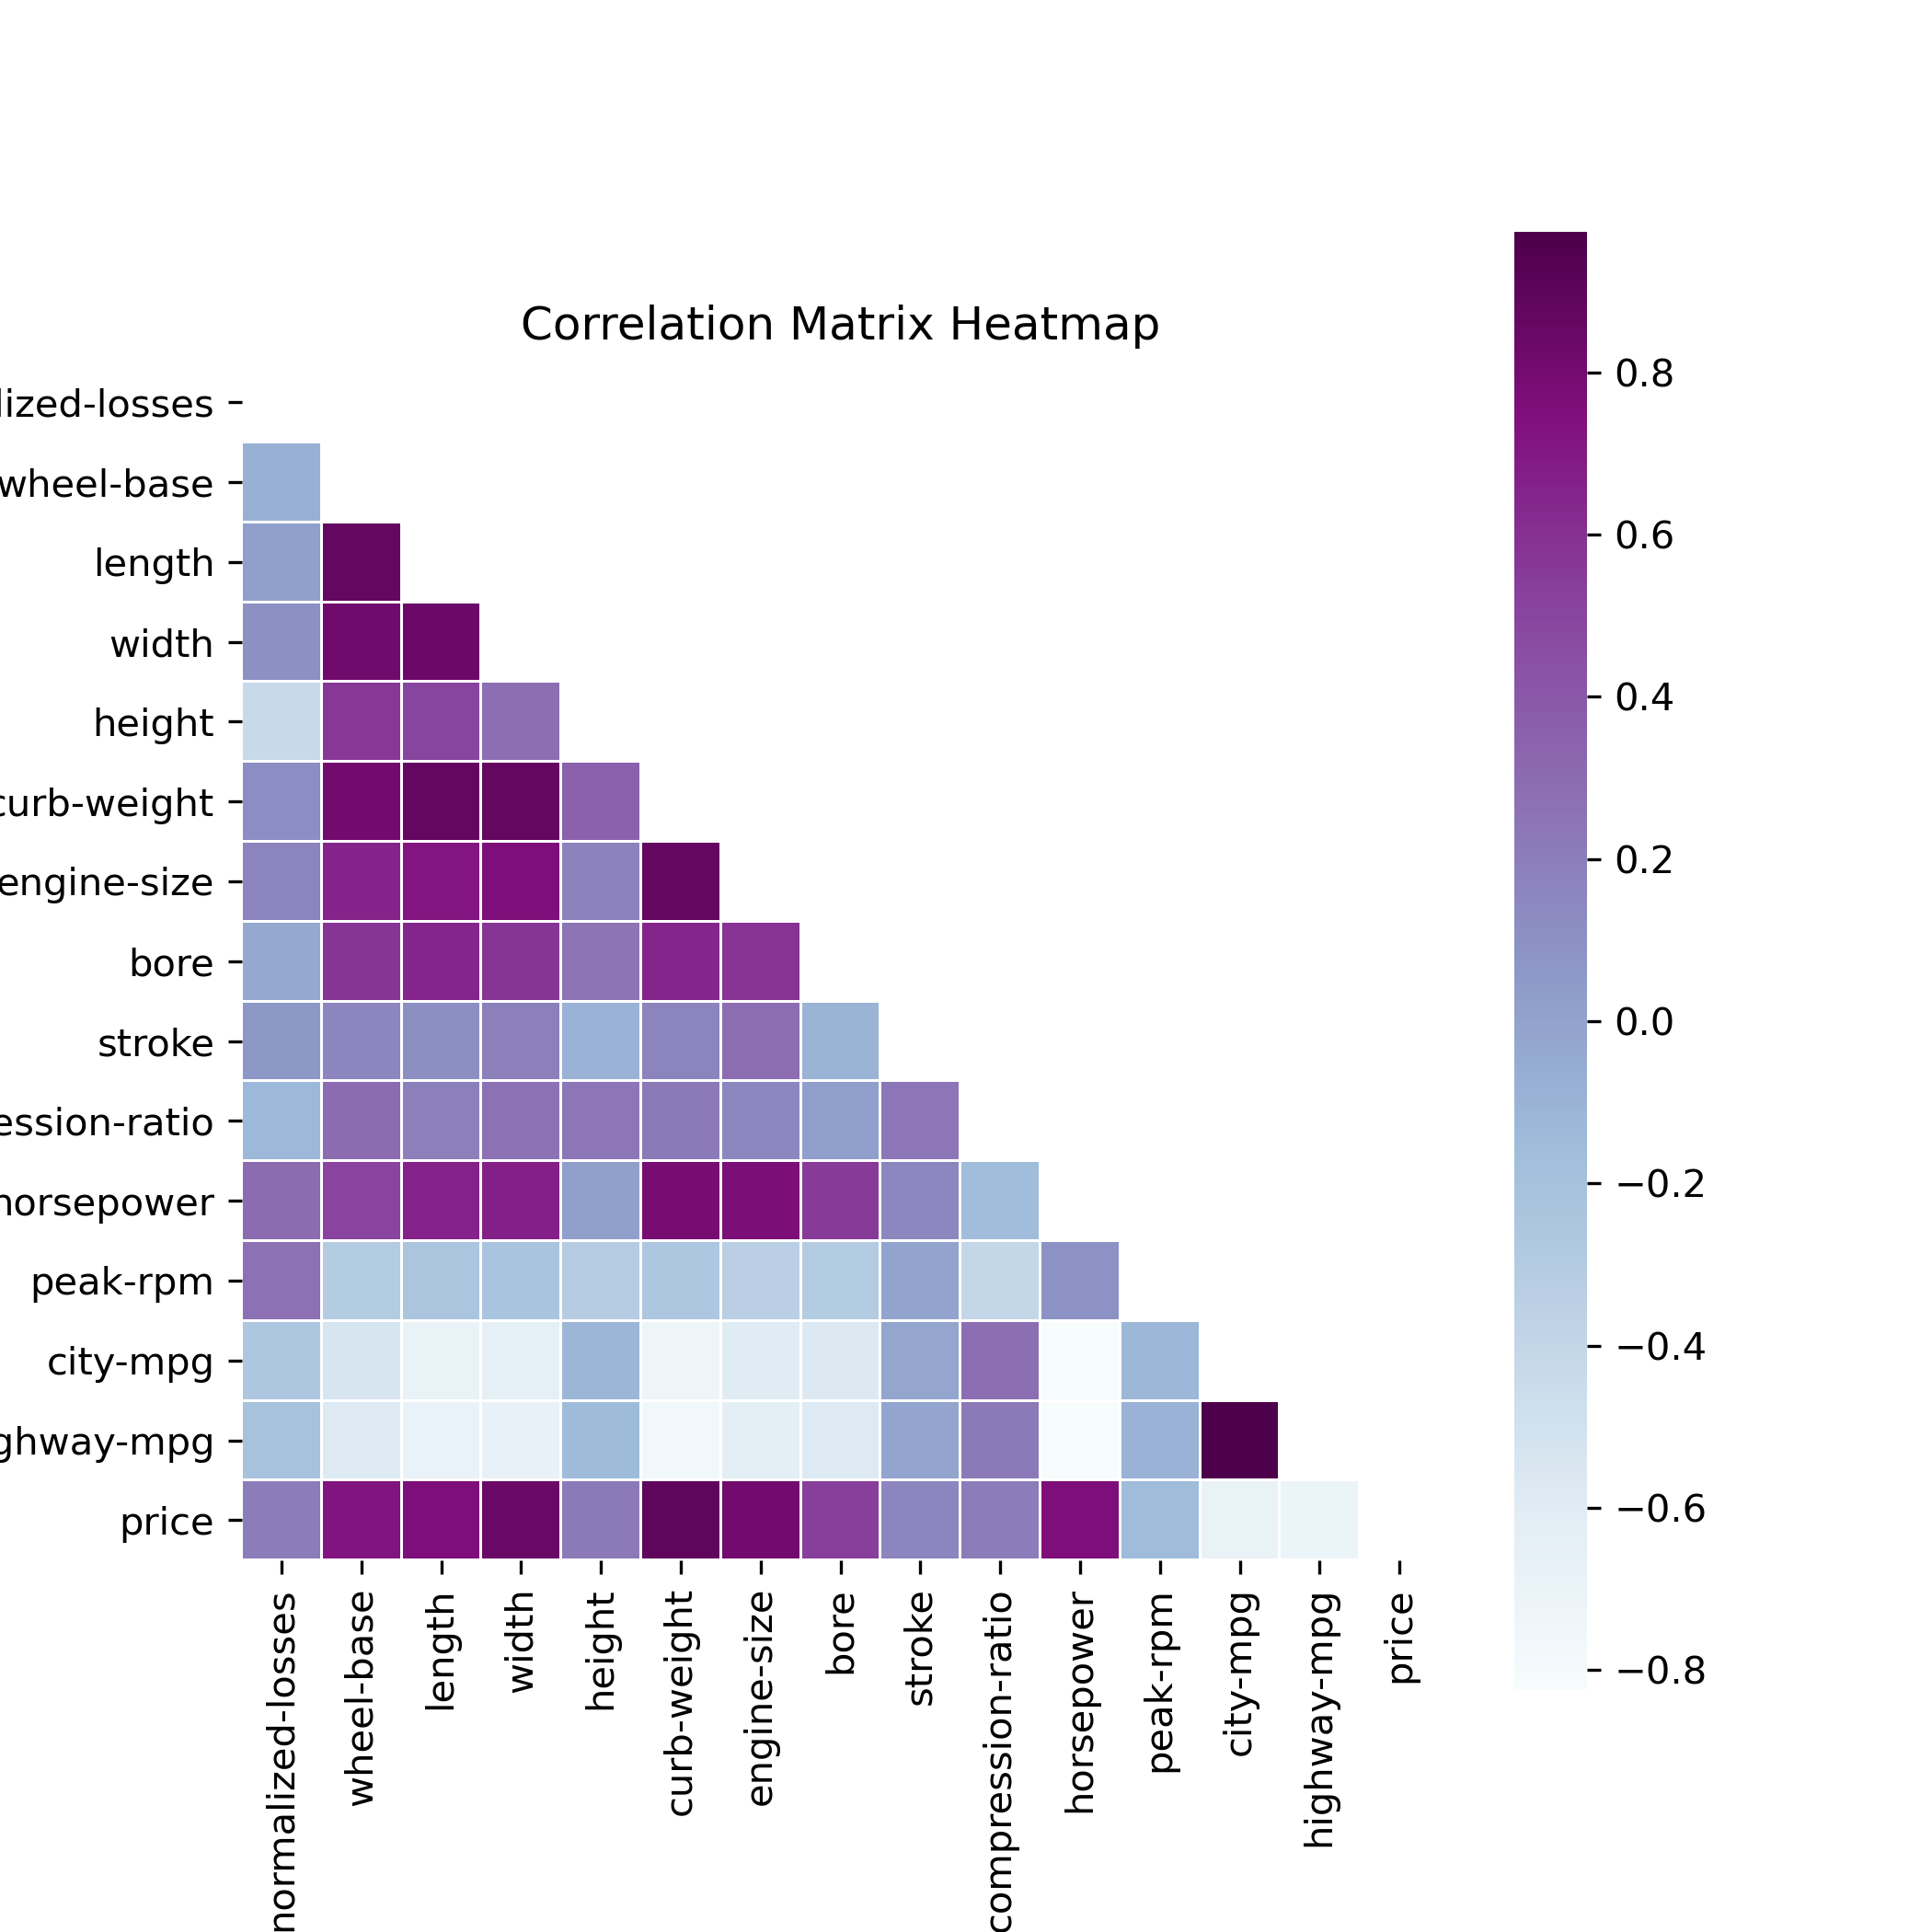

In [17]:
Image("img/correlation_heatmap.png", width = 600)

- Strong positiv & strong negative correlations between some features
- Multicollinearity

# 3. Solution
We'll create a base model without further preprocessing, thereby ignoring the flaws we just found. After that we'll try a model build with PyCaret.

In [7]:
data = df.sample(frac=0.9, random_state=seed)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

In [19]:
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (148, 25)
Unseen Data For Predictions: (16, 25)


## Base Model
Let's consider continuous variables only (fast).

In [9]:
cols = list(data.columns)
target, num_features = cols[0], [c for c in cols[1:] if c in numerics]

In [10]:
X,y = data[num_features], data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

In [11]:
model = LinearRegression().fit(X_train, y_train)
summary(model, X_train, y_train)

Call:
lm(formula = normalized-losses ~ wheel-base + length + width + height + curb-weight + engine-size + bore + stroke + compression-ratio + horsepower + peak-rpm + city-mpg + highway-mpg + price) 

                       Coefficients  Std. Error  t value  Pr(>|t|)
0         (Intercept)      573.8657     214.309    2.678     0.008
1          wheel-base        0.5757       1.331    0.433     0.666
2              length        0.2323       0.677    0.343     0.732
3               width       -1.4625       3.441   -0.425     0.672
4              height       -7.5976       1.692   -4.491     0.000
5         curb-weight        0.0192       0.022    0.858     0.392
6         engine-size        0.0765       0.244    0.313     0.755
7                bore      -30.2625      14.769   -2.049     0.042
8              stroke      -10.7359      10.732   -1.000     0.319
9   compression-ratio        0.1486       1.073    0.138     0.890
10         horsepower       -0.0592       0.254   -0.233     0.

In [26]:
MSE = round(mean_squared_error(y_test, model.predict(X_test)),2)
RMSE = round(mean_squared_error(y_test, model.predict(X_test), squared=False),2)

print(f"MSE: {MSE}",f"RMSE: {RMSE}", sep="\n")

MSE: 605.04
RMSE: 24.6


Considering that we did this just quick and dirty, an RMSE of 24.6 seems not too bad. Right? Let's see some pictures.

### Prediction Distributions

In [34]:
predictions = model.predict(data_unseen[num_features])
truth = data_unseen["normalized-losses"].to_numpy()
sns.histplot(predictions, bins=15)
sns.histplot(truth, bins=25, color="orange")
plt.suptitle("Simple Model")
plt.title("Distribution predicted vs real normalized-losses on unseen data")
plt.legend(["y_hat", "y_true"])
plt.savefig('img/dist_pred_vs_real_unseen.png', dpi=300)
plt.close()

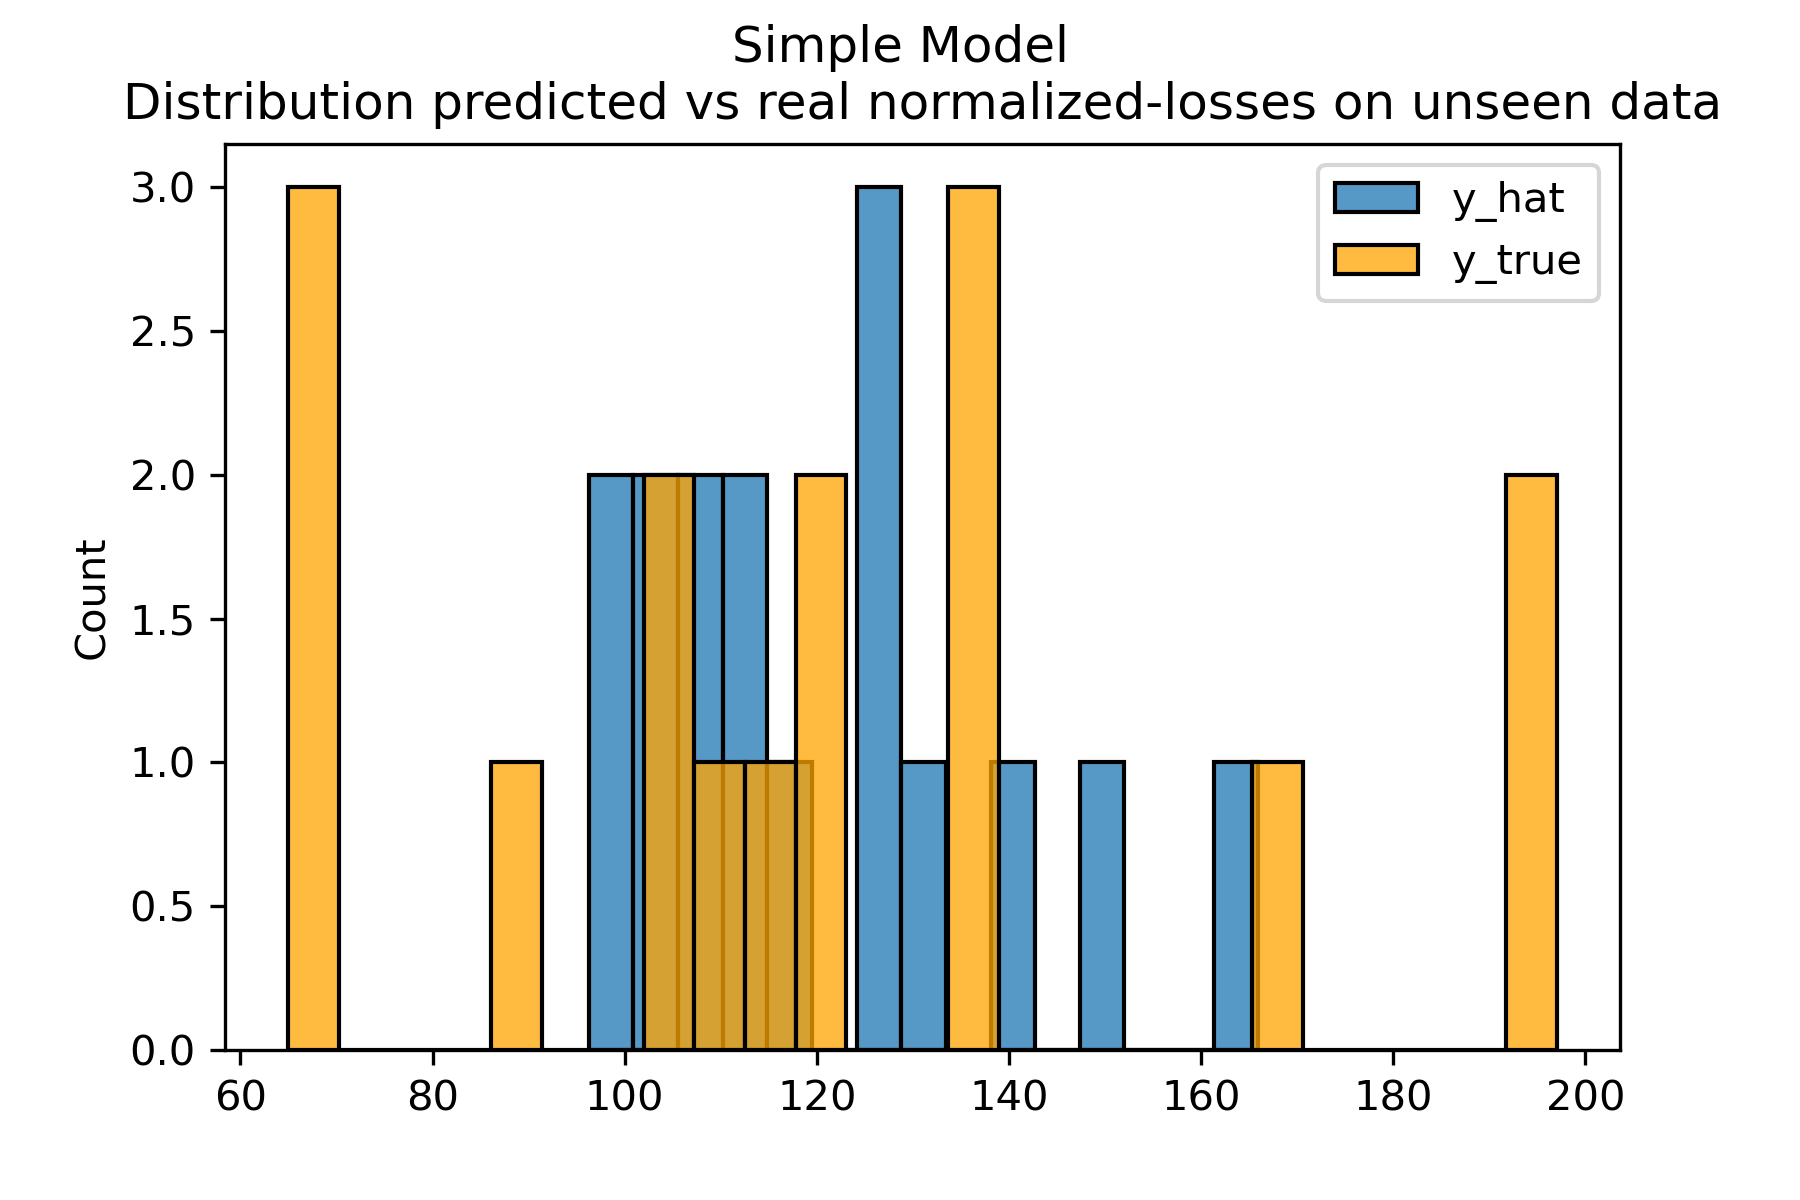

In [35]:
Image("img/dist_pred_vs_real_unseen.png", width = 600)

- Very small validation set
- Looks "OK-ish" though

In [36]:
predictions = model.predict(data[num_features])
truth = data["normalized-losses"].to_numpy()
sns.histplot(predictions, bins=15)
sns.histplot(truth, bins=25, color="orange")
plt.suptitle("Simple Model")
plt.title("Distribution predicted vs real normalized-losses on seen data")
plt.legend(["y_hat", "y_true"])
plt.savefig('img/dist_pred_vs_real_seen.png', dpi=300)
plt.close()

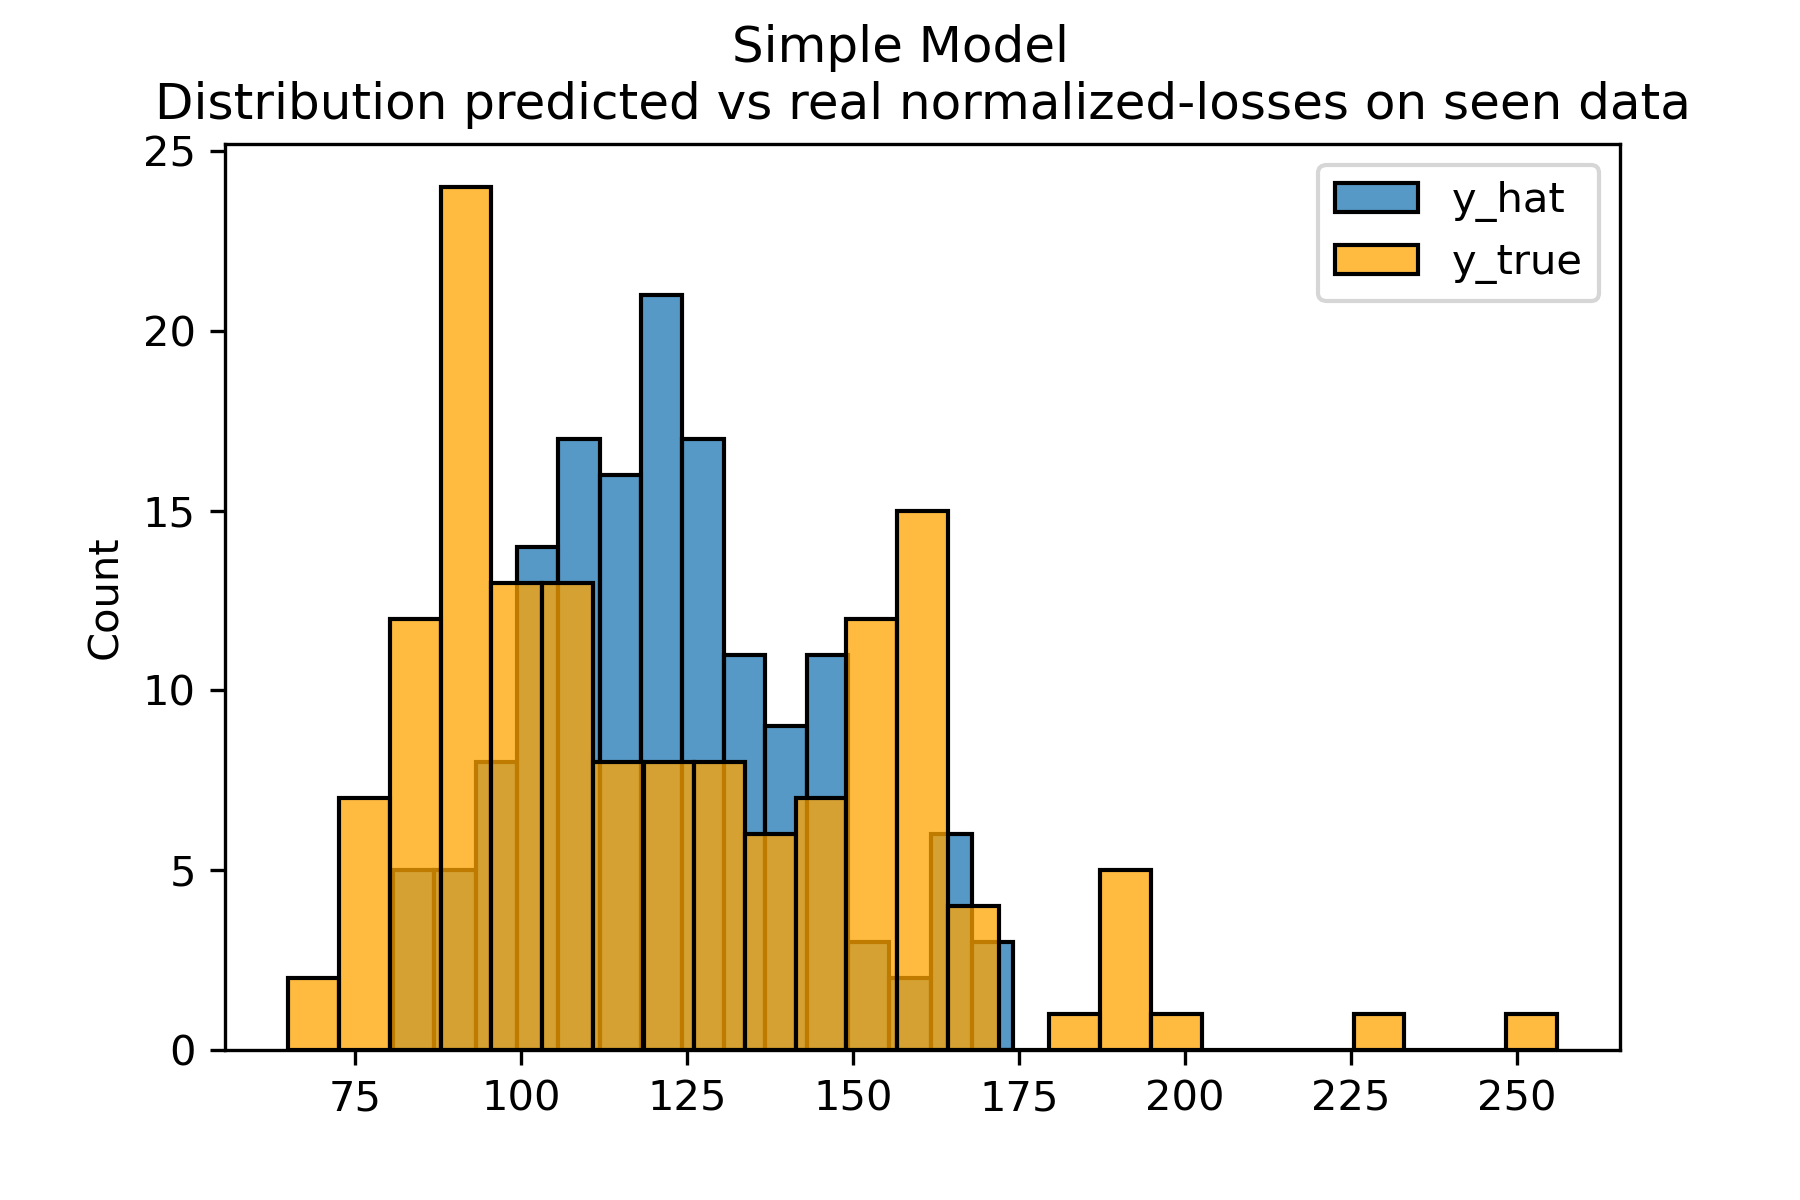

In [37]:
Image("img/dist_pred_vs_real_seen.png", width = 600)

- predictions on training data
- model assumes target normaly distributed

## Modeling fun with PyCaret
Instead of dealing with issues like strong correlations between features manually and doing a parameter optimization in a similar fashion, let's figure out if PyCaret can deal with that out of the box.

### Prepare the stage

In [12]:
params = {
    "data": data,
    "target": "normalized-losses",
    "train_size": 0.8,
    "categorical_features": [c for c in cols[1:] if c not in numerics],
    "remove_multicollinearity": True,
    "verbose": False,
    "silent": True,
    "fold": 10,
    "session_id": seed,
}
regr = setup(**params)

So easy to setup 🙂

### Find best models (lowest MSE)

In [13]:
top3 = compare_models(n_select = 3,sort = 'MSE',
                      exclude=['huber','lar','par', 'knn', 'llar', 'br', 'en','lr'],
                      verbose=False)

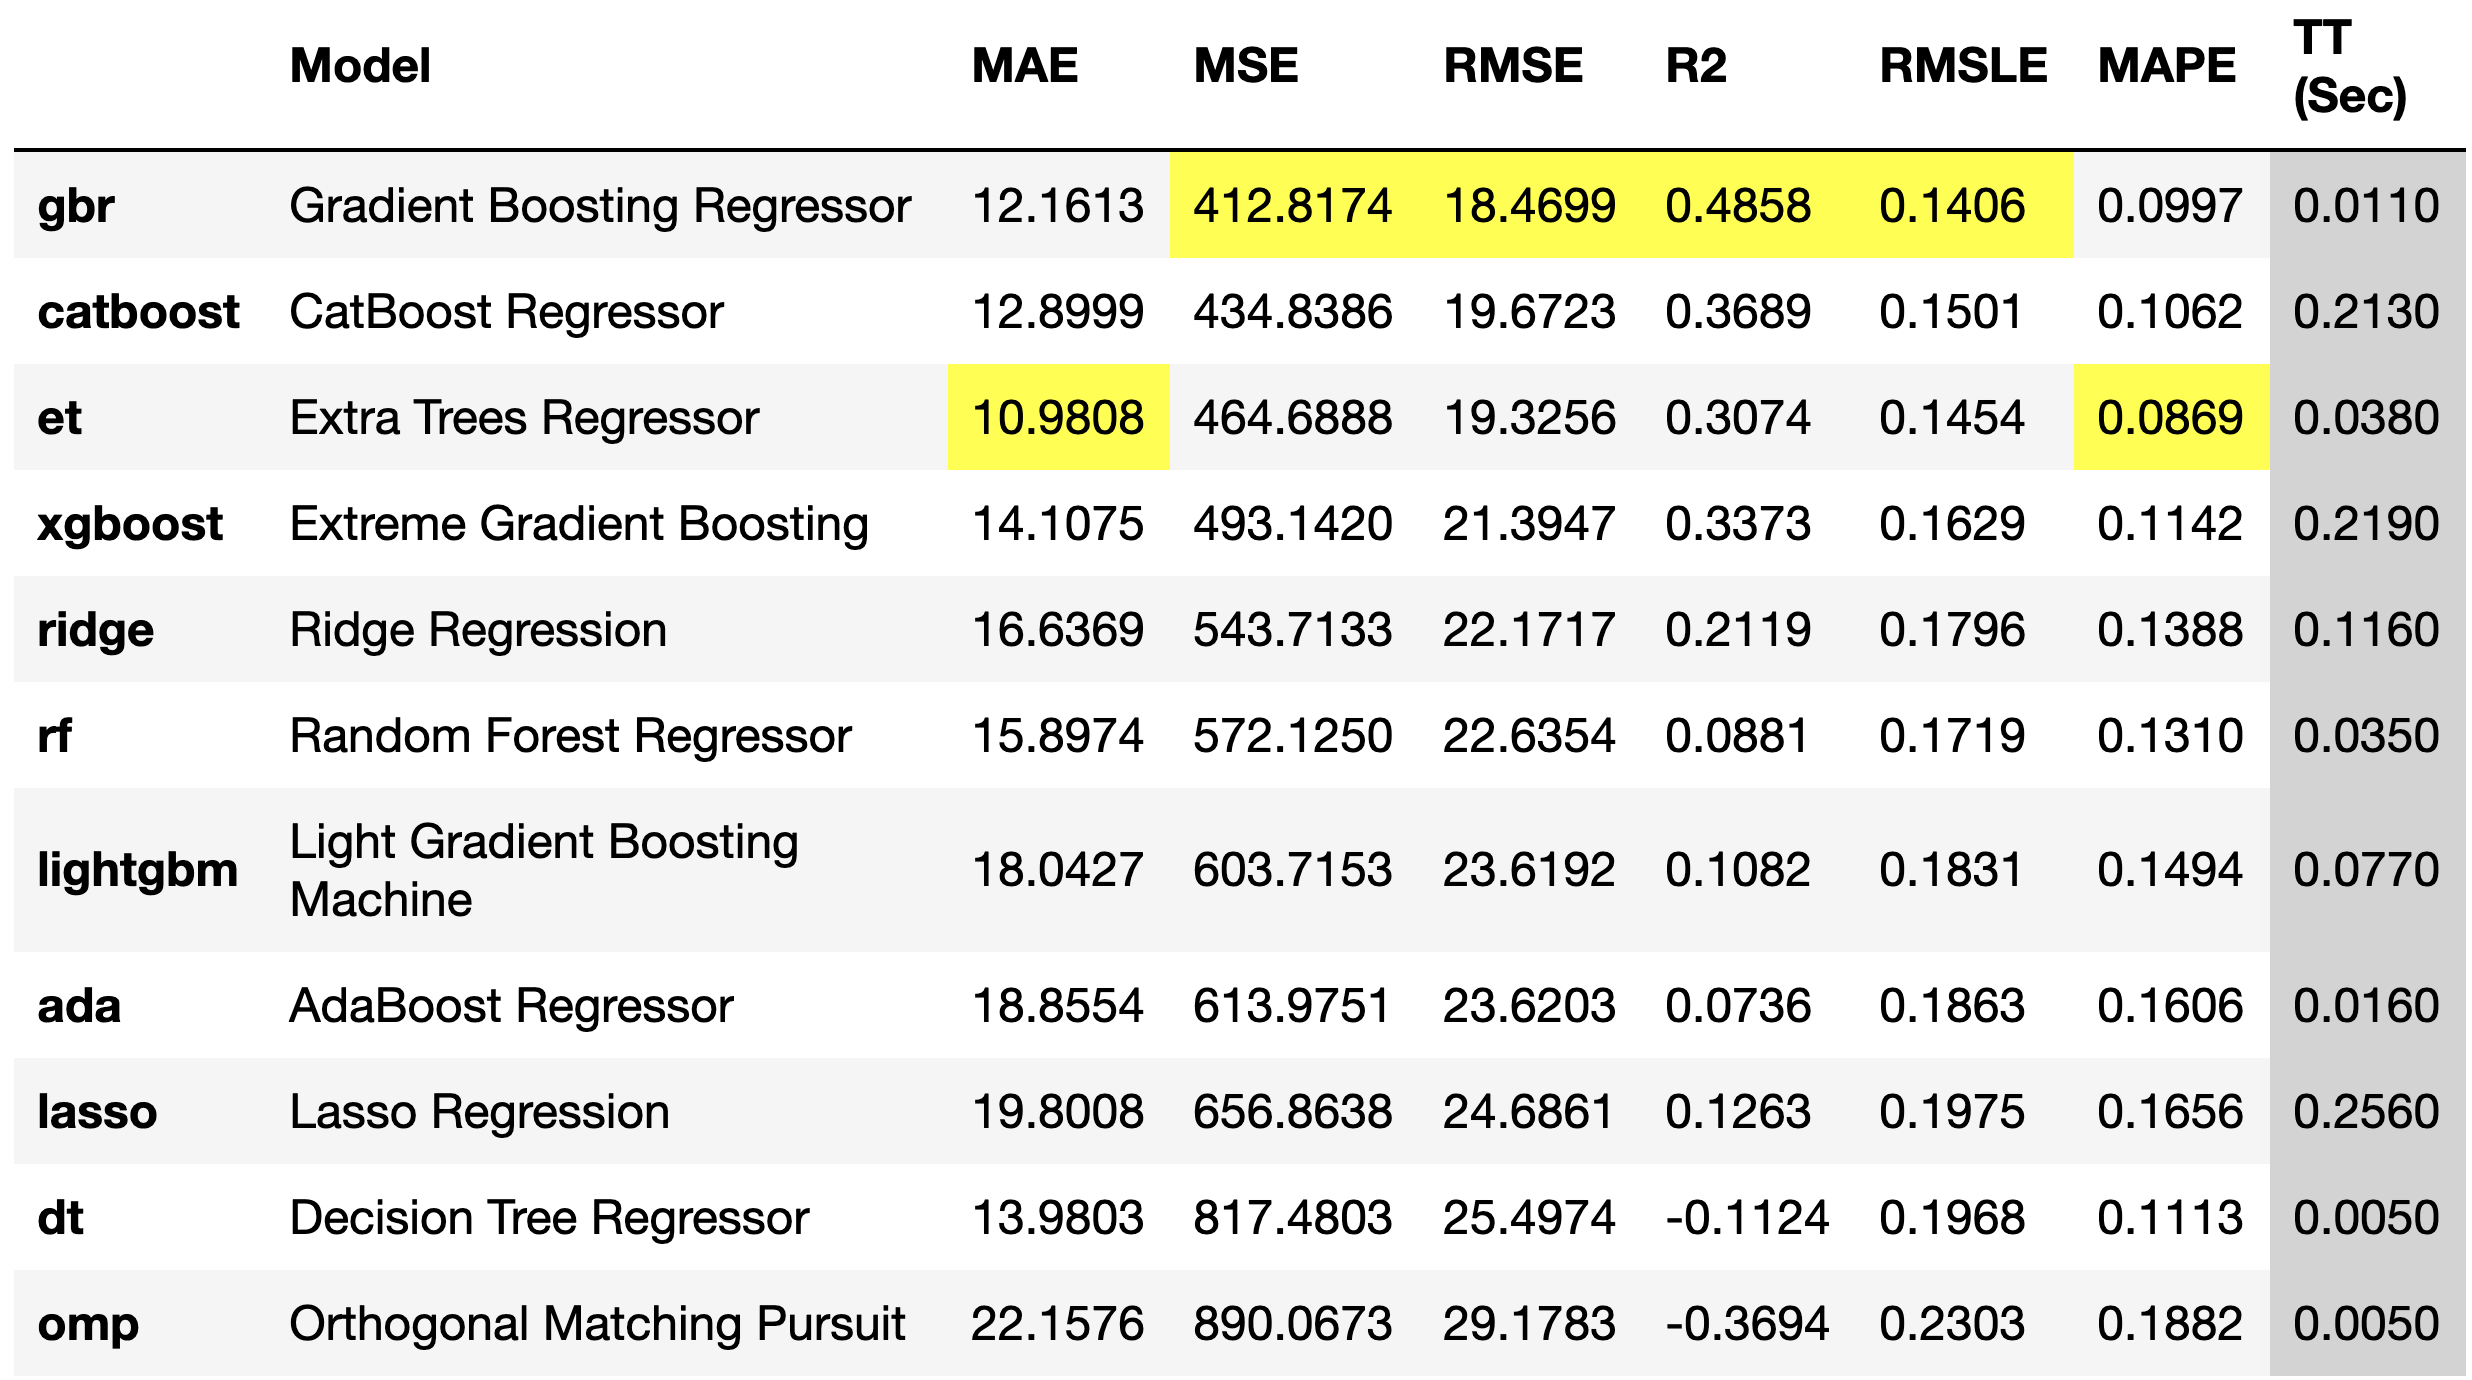

In [14]:
Image("img/top3.png", width = 600)

Out of the box state of the art models seem to perform well.

### Stack them together

In [17]:
stacker = stack_models(estimator_list = top3[1:], meta_model = top3[0], verbose=False)

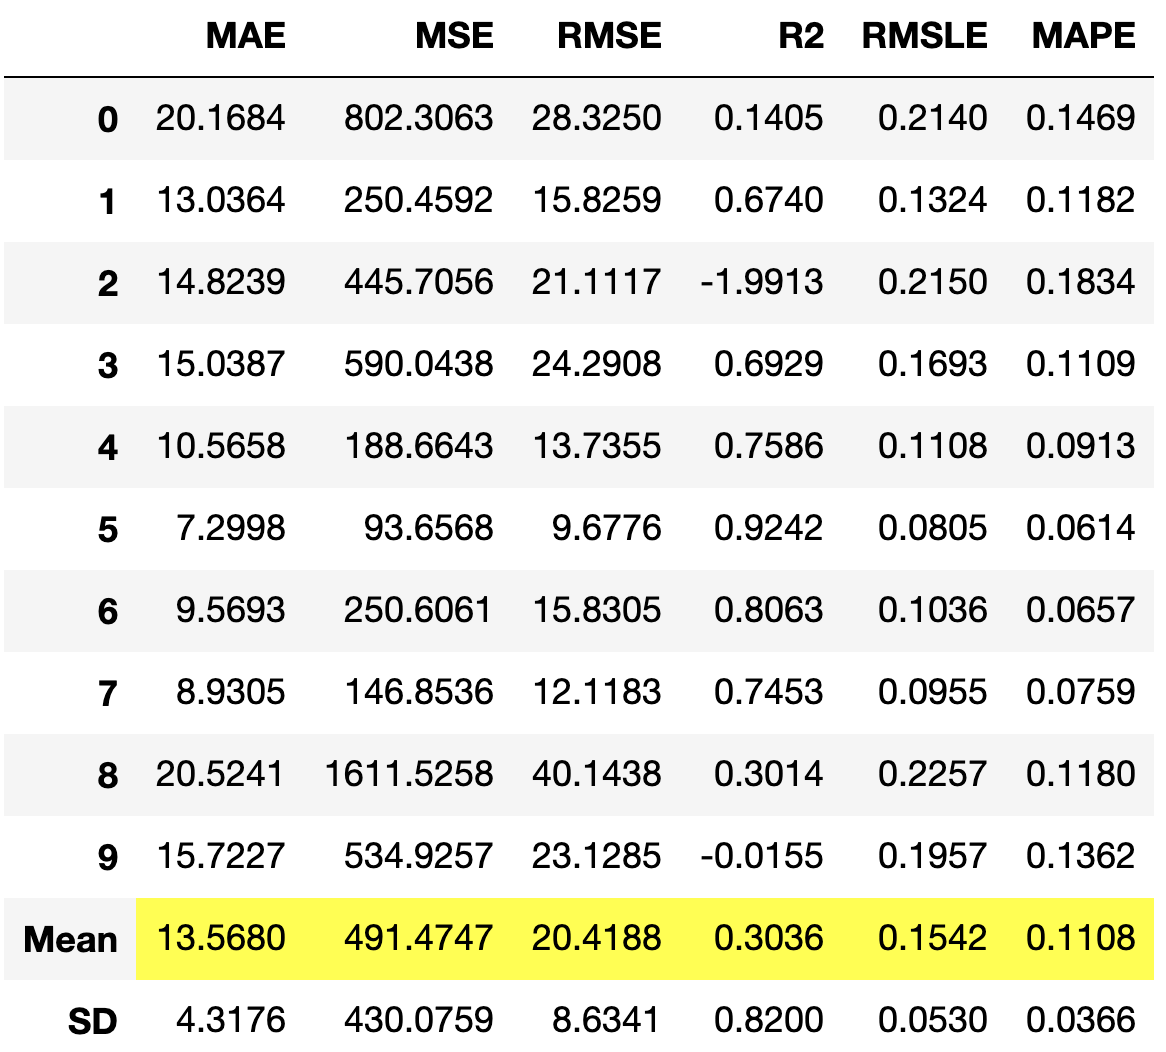

In [19]:
Image("img/stacked.png", width = 400)

Quite a high standard deviation for MSE within our ensemble.

### Tune ensemble model

In [21]:
tuned_best_model_optuna = tune_model(
    stacker,
    search_library="tune-sklearn",
    search_algorithm="optuna",
    n_iter=3,
    optimize = "MSE",
    verbose=False
)

[I 2021-05-02 12:01:34,655] A new study created in memory with name: optuna


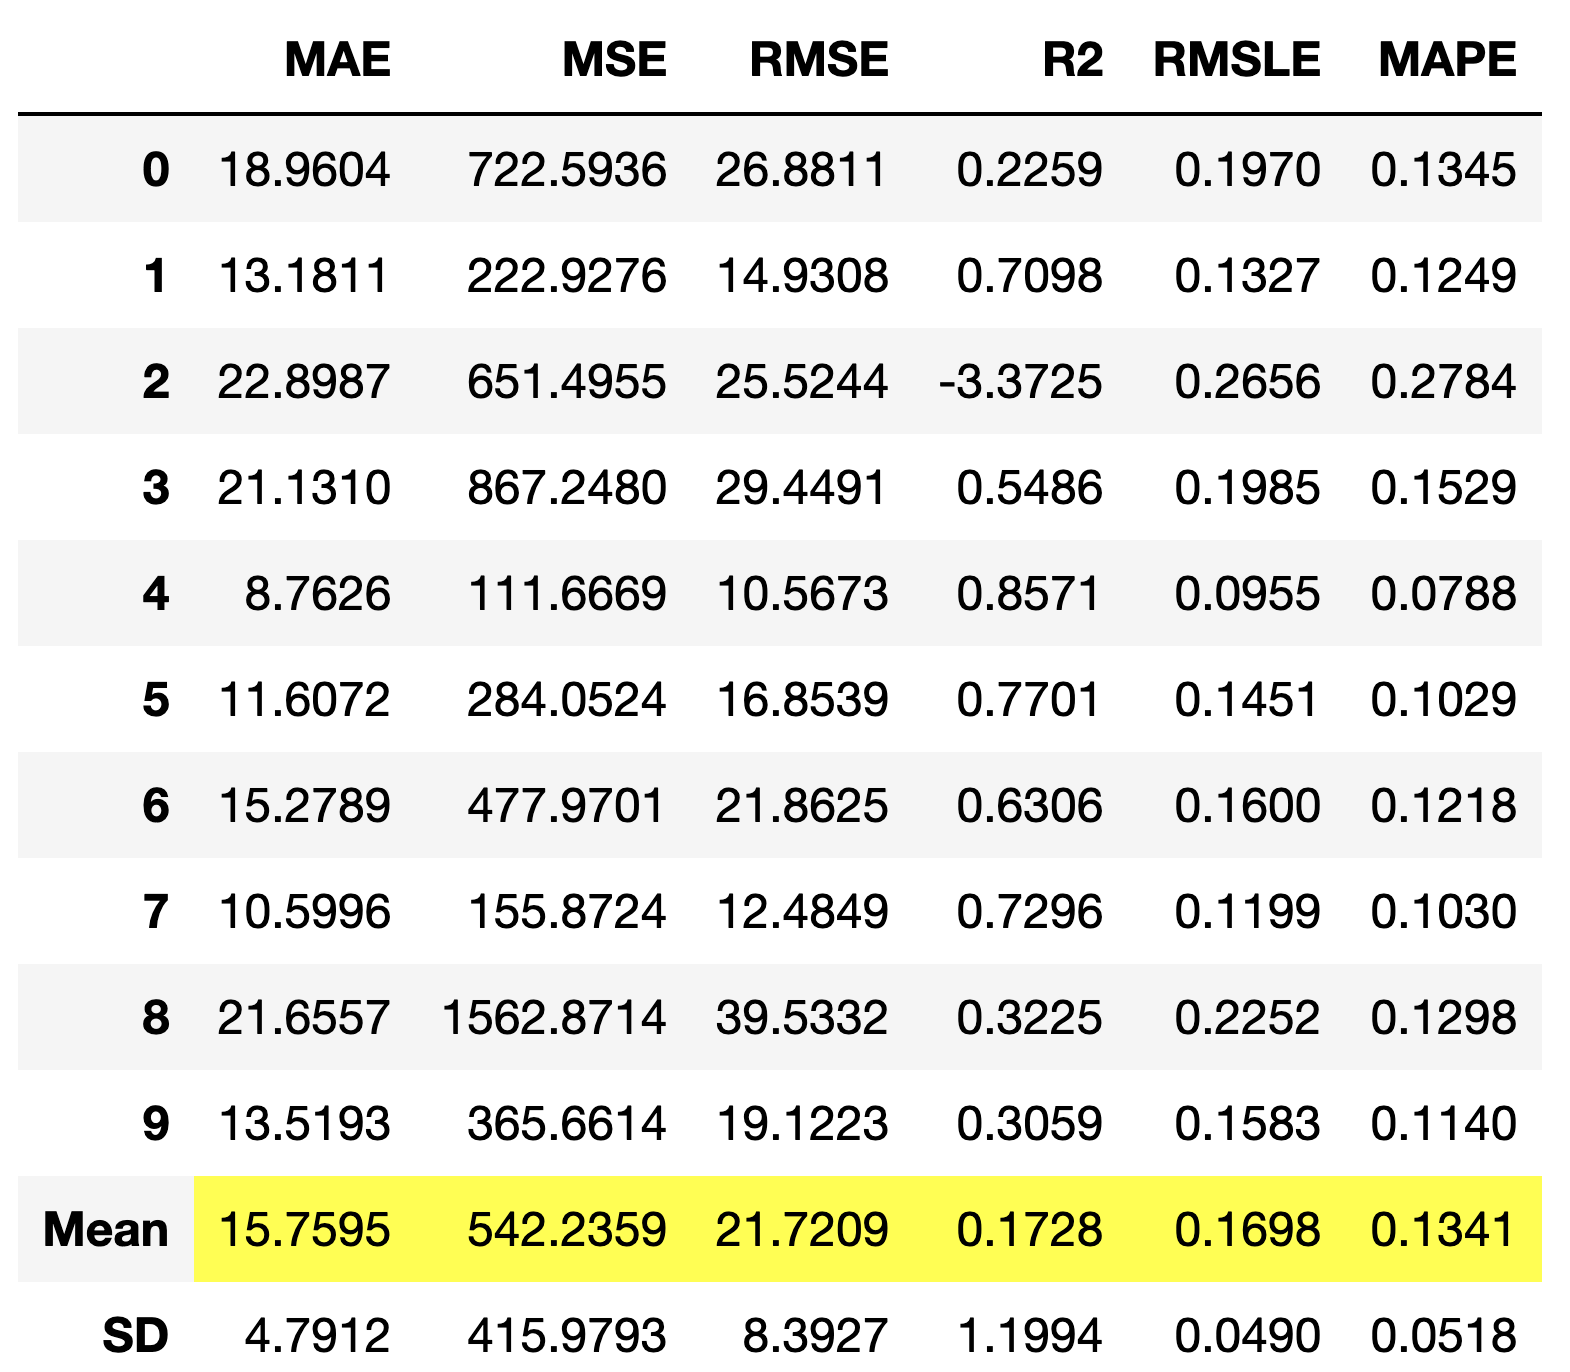

In [22]:
Image("img/tuned.png", width = 400)

- Instead of going through lots of bad hyperparameter settings via RandomizedSearchCV() or GridSearchCV(), we did a Bayesian optimization with `tune-sklearn`. Pretty cool & pretty fast 😉. 
- Note, that the standard deviation for MSE slightly decreased.
- Only 3 iterations to avoid further overfitting

### Prediction Error

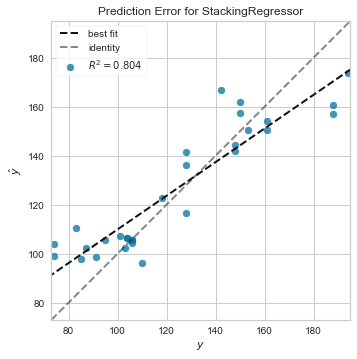

In [80]:
plot_model(tuned_best_model_optuna, 'error')

- No exact match between real normalized losses and predicted ones (y_hat)
- Error increases with distance from normalized losses of 130

### Residuals

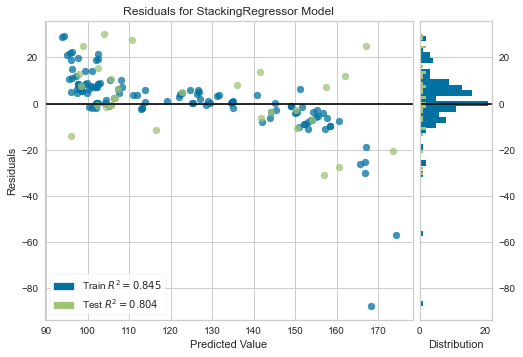

In [81]:
plot_model(tuned_best_model_optuna, 'residuals')

- similar to previous graph: 
    - the bigger the target value, the greater the error
- fit seems ok .84 vs .80

In [84]:
save_model(stacker, "model/stacked_regressior_01")
print()

Transformation Pipeline and Model Succesfully Saved



### Prediction Distributions

In [35]:
stacker = load_model("model/stacked_regressior_01")

predictions = predict_model(stacker, 
                            data = data_unseen[
                                list(data_unseen.columns)[1:]
                            ])["Label"].to_numpy()

truth = data_unseen["normalized-losses"].to_numpy()

sns.histplot(predictions, bins=20)
sns.histplot(truth, bins=25, color="orange")
plt.suptitle("Stacked Model")
plt.title("Distribution predicted vs real normalized-losses on unseen data")
plt.legend(["y_hat", "y_true"])
plt.savefig('img/dist_pred_vs_real_unseen_stacked.png', dpi=300)
plt.close()

Transformation Pipeline and Model Successfully Loaded


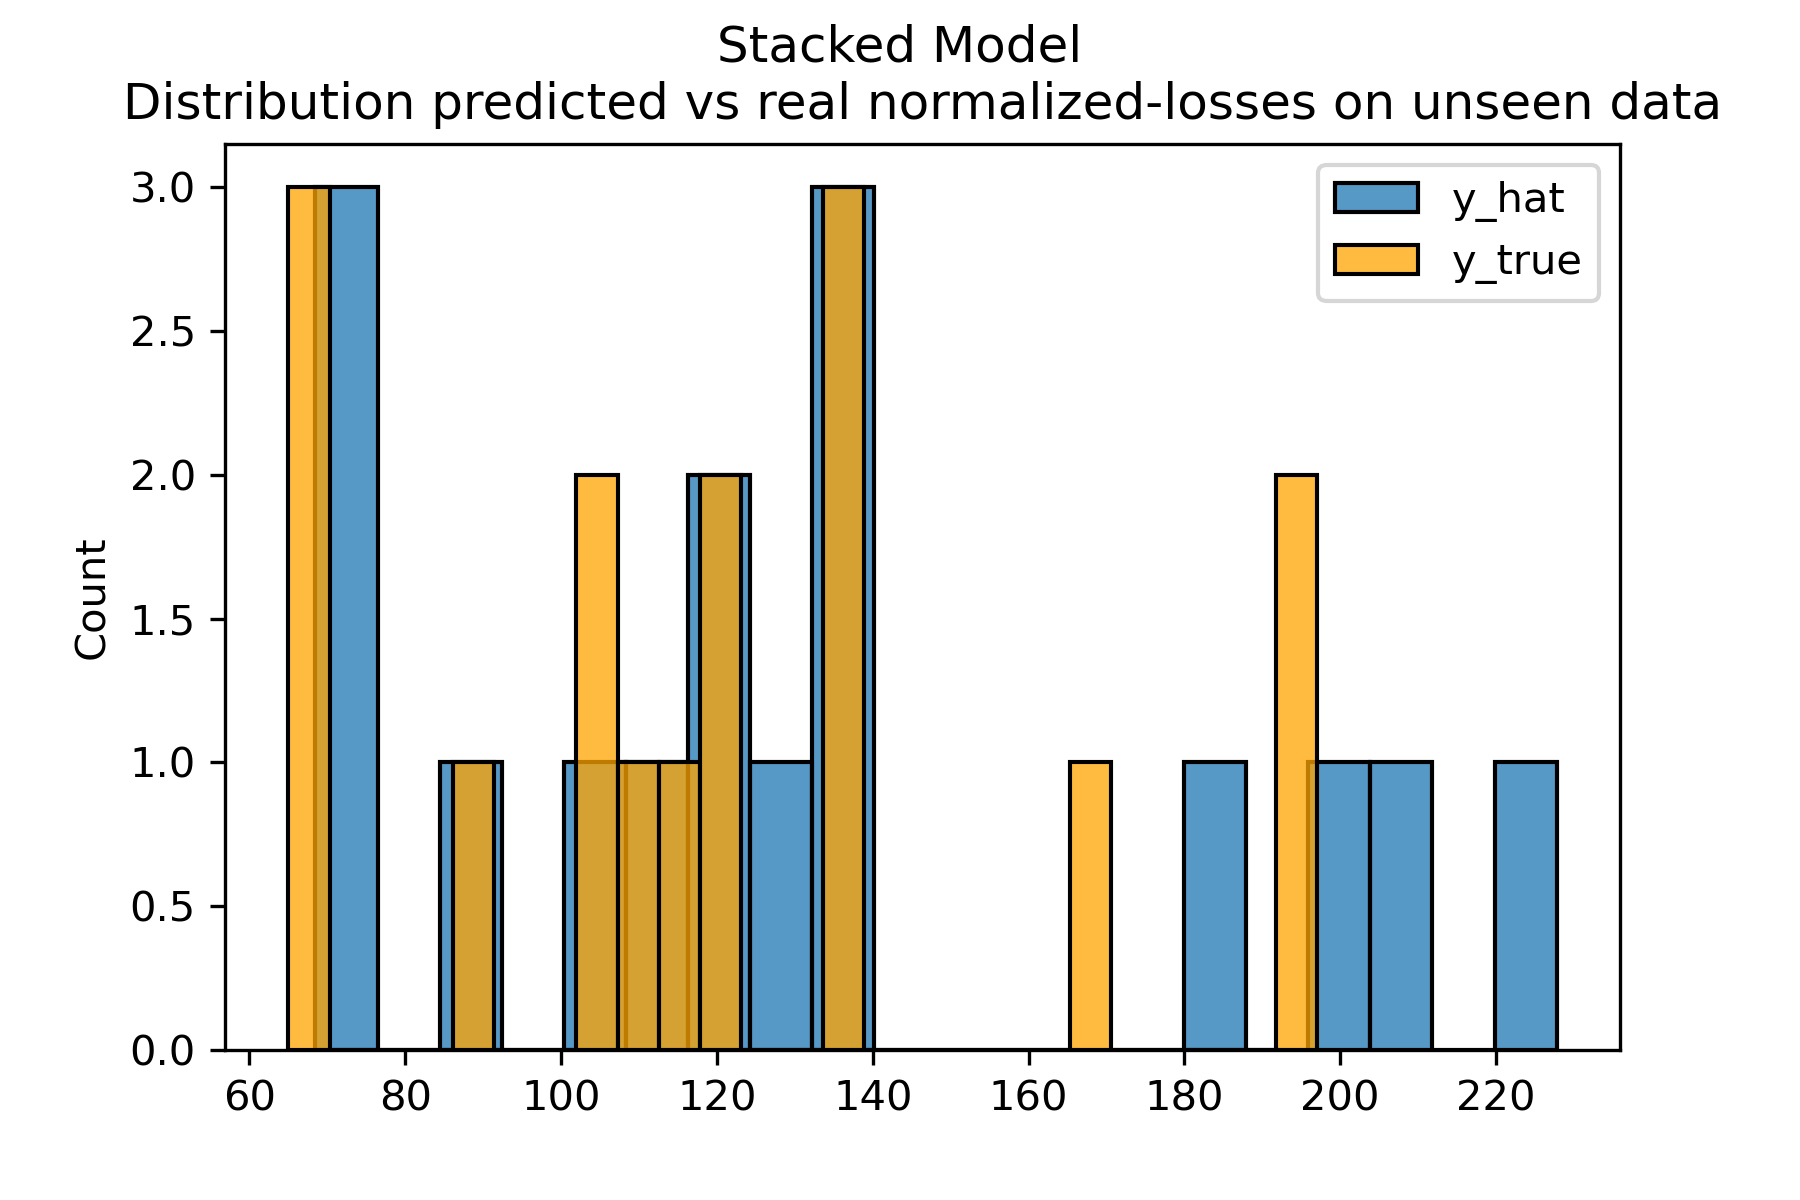

In [36]:
Image("img/dist_pred_vs_real_unseen_stacked.png", width = 600)

- Stacked model slightly better performance than base model on new data.
- Errors seem to increase with value of normalized losses

In [37]:
predictions = predict_model(stacker, 
                            data = data[
                                list(data_unseen.columns)[1:]
                            ])["Label"].to_numpy()

truth = data["normalized-losses"].to_numpy()

sns.histplot(predictions, bins=20)
sns.histplot(truth, bins=25, color="orange")
plt.suptitle("Stacked Model")
plt.title("Distribution predicted vs real normalized-losses on seen data")
plt.legend(["y_hat", "y_true"])
plt.savefig('img/dist_pred_vs_real_seen_stacked.png', dpi=300)
plt.close()

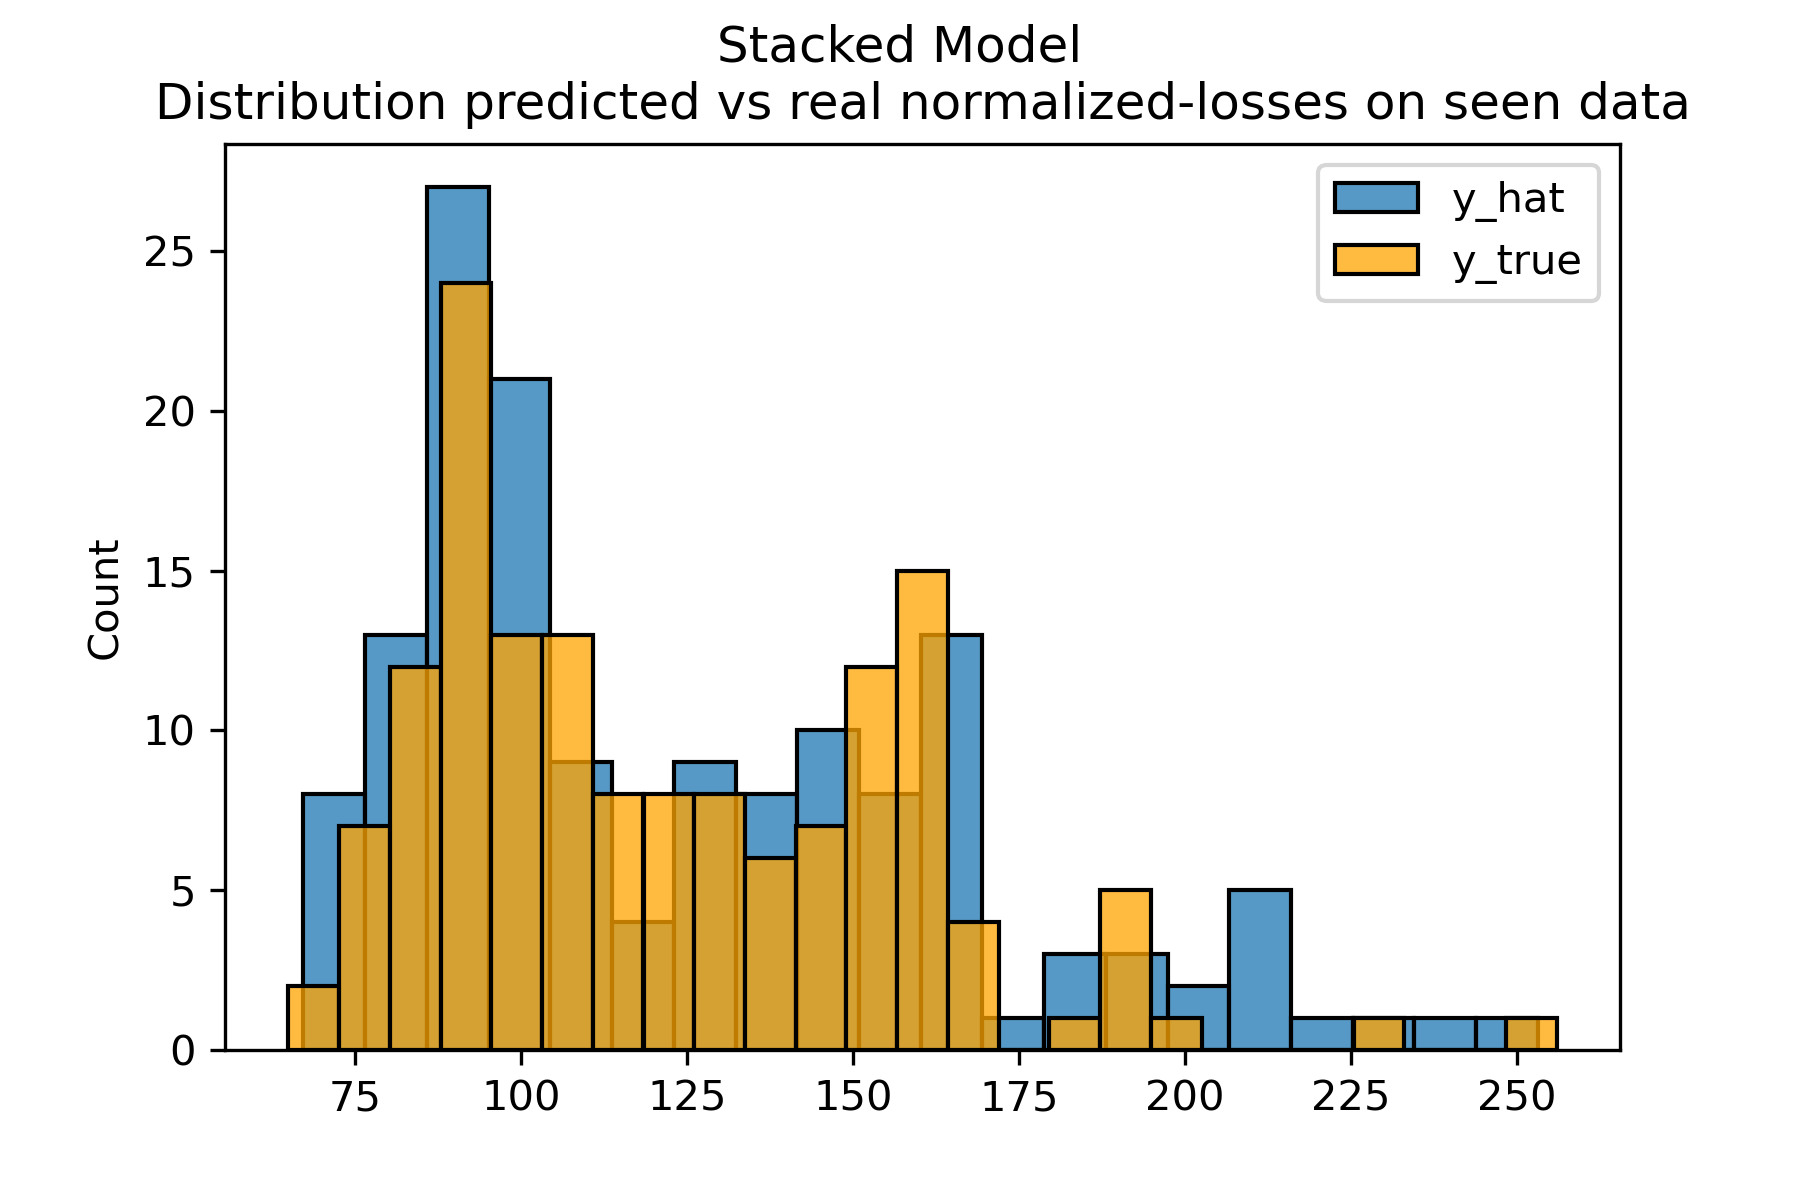

In [38]:
Image("img/dist_pred_vs_real_seen_stacked.png", width = 600)

- Predictions on seen data pretty close to y_true

# Conclusion
- We worked with an **extremely small data set**. This may be suffient in a research setting. However, in practice it is recommended to work with as much data as possible (#rows > 100k). Hence, in business cash matters, not the p-value.

- We used **very clean data**. In reality we'd have spent several days just for preprocessing 😉.

- **PyCaret was fun!** Incredible how much time we could save by using this framework. I'll work more with it.

- 감사합니다 🙂

# Sources
- https://boostedml.com/2019/06/linear-regression-in-r-interpreting-summarylm.html
- https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
- https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c
- https://stackoverflow.com/questions/49392448/possible-to-host-a-website-with-google-cloud-without-a-domain
- https://cloud.google.com/storage/docs/hosting-static-website-http#console
- https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
- https://www.kdnuggets.com/2021/03/bayesian-hyperparameter-optimization-tune-sklearn-pycaret.html

# Appendix: Production Scenario